In [87]:
from scipy.optimize import fsolve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [88]:
%run stdPackages.ipynb
slides = False # print to slides format if True
out_folder = os.path.join(d['curr'], 'Misc', 'Figs')
d['data'] = os.path.join(d['curr'],'Misc','Data')
read = {'variables': ['Fundamentals', 'Load', 'Generators_Other'], 
        'variable2D': ['Generators_FuelMix','HourlyVariation'],
        'scalars': ['Scalars'],
        'maps': ['Generators_Categories']}
db = dbFromWB(os.path.join(d['data'],'mBasicInt_StorageExperiment.xlsx'), read)
readSets(db)

### Set up model and solve:

In [89]:
m = mBasicInt.mSimple(db)
m.solve()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


*Specify CES demand:*

In [90]:
pj_ini = np.array(m.db['marginalSystemCosts'])
Ej_ini = np.array(m.db['HourlyDemand'])
I = sum(E*pj) # Total expenditures=Income
p_ini = I/sum(Ej_ini) # Iniatal yearly price index
σ = 1.5
f_pCES = lambda μj,pj,σ: (μj[0]*pj[0]**(1-σ)+μj[1]*pj[1]**(1-σ))**(1/(1-σ))
f_qCES = lambda μj,pj,p,σ:  μj*(pj/p)**(-σ)*I/p
v_qCES = np.vectorize(f_qCES,excluded=['I','p'])
def f_μCalib(x0,*params):
    x = x0
    pj,xj,σ,I, = params
    return (
        xj[0] - x[0]*(pj[0]/x[2])**(-σ)*I/x[2], # Demand in h=1
        xj[1] - x[1]*(pj[1]/x[2])**(-σ)*I/x[2], # Demand in h=2
        x[2]-(x[0]*pj[0]**(1-σ)+x[1]*pj[1]**(1-σ))**(1/(1-σ)) # Yearly price index
    )

params = (pj_ini,Ej_ini,σ,I)
μ1,μ2,p = fsolve(f_μCalib, x0=[0.5,0.5,p_ini], args=params)
μj = [μ1,μ2]

*Check it is correct:*

In [94]:
p = f_pCES(μj,pj_ini,σ=σ)
Ej = v_qCES(μj=μj,pj=pj_ini,p=p,σ=σ)

*Specify iterative solution algorithm:*

In [159]:
def solve_with_flexible_demand(ϵ,max_iter,params):
    # Book-keeping
    n_iter = 0
    Obj = 10
    
    # Unpack parameters:
    σ,I = params # ϵ is the absolute error allowed
    
    while (Obj>=ϵ) | (n_iter>=max_iter):
        
        # b) Solve linear programming model:
        m.solve()

        # c) Get results from linear programming model:
        pj_LPmodel = np.array(m.db['marginalSystemCosts'])
        Ej_LPmodel = np.array(m.db['HourlyDemand'])

        # c) Update demand
        p = f_pCES(μj,pj_LPmodel,σ=σ) # Update price index
        Ej = v_qCES(μj=μj,pj=pj_LPmodel,p=p,σ=σ) # Update demand

        # e) Check condition:
        Obj = ((Ej-m.db['HourlyDemand'])**2).sum()

        # d) Update parameters in linear programming model
        m.db['Load'] = pd.Series(sum(Ej),index=m.db['Load'].index,name='Load')
        m.db['LoadVariation'] = pd.Series(Ej/sum(Ej),index=m.db['LoadVariation'].index,name='LoadVariation')
        
        # Update number of iterations:
        n_iter += 1
    
    return {'m':m,'n_iterations':n_iter-1,'PriceIndex':p}

In [160]:
solve_with_flexible_demand(ϵ=0.0001,max_iter=10,params=(σ,I))

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


{'m': <mBasicInt.mSimple at 0x22f8fbbb9d0>,
 'n_iterations': 1,
 'PriceIndex': 8.803044585849516}

### Plot merit order curve for each hour:

In [4]:
def demand_h(m,h):
    return standardPlots.demandLinear_df(m.db['MWP_LoadShedding'], m.hourlyLoad.xs(h))
def supply_h(m,h,maxY=30):
    return standardPlots.meritOrderCurve_df(m.db['mc'], m.hourlyGeneratingCapacity.xs(h,level='h'),maxY=maxY)

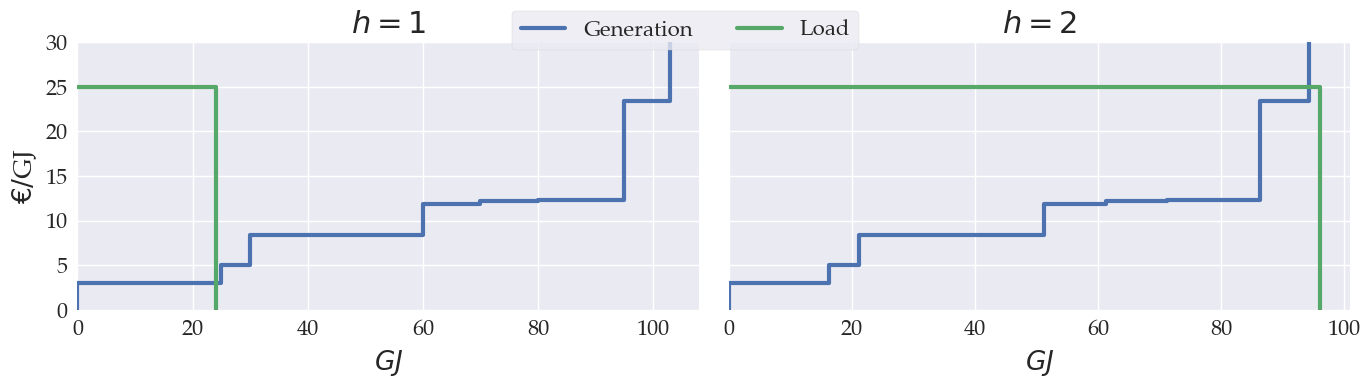

In [5]:
# %%capture
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=True);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    h = j+1
    df = supply_h(m,h)
    dh = demand_h(m,h)
    
    df.plot(linewidth=3,ax=ax,legend=False);
    dh.plot(linewidth=3,ax=ax,legend=False);
    ax.set_xlabel(r'$GJ$', labelpad = 5);
    ax.set_ylabel(r'$€/$GJ', labelpad = 5);
    ax.set_xlim([0, max([dh.index.max(), df.index.max()])+5]);
    ax.set_ylim([0, math.ceil(max([df.max()[0], dh.max()[0]]))]);
    ax.set_title(f"""$h={h}$""")
    
    
fig.legend(['Generation', 'Load'],loc=9,ncol=2,frameon=True)
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_MeritOrder_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_MeritOrder.pdf",edgecolor='k')

### Plot marginal fuel consumption and CO2 emissions for each hour:

*Make database:*

In [6]:
def other_from_supply(h,mc,production,other):
    production = production.xs(h,level='h')
    df = pd.concat({**{'c':mc,'q':production},**{x:other[x] for x in other.columns}},axis=1).sort_values(by='c').drop(columns='c')
    df = df[df['q']>0]
    df['q'] = df['q'].cumsum()
    df_up = df.copy()
    df_up['q'] = df_up['q']+np.finfo(float).eps
    df_up[other.columns.values] = df_up[other.columns.values].shift(-1)
    df = df.append(df_up.dropna()).sort_values('q').set_index('q')
    df.loc[0] = [0]*len(other.columns)
    return df.sort_index()

def other_from_prices(h,mc,production,other):
    production = production.xs(h,level='h')
    df = pd.concat({**{'c':mc,'q':production},**{x:other[x] for x in other.columns}},axis=1).sort_values(by='c').drop(columns='q')
    df_up = df.copy()
    df_up['c'] = df_up['c']+np.finfo(float).eps
    df_up[other.columns.values] = df_up[other.columns.values].shift(-1)
    df = df.append(df_up.dropna()).sort_values('c').set_index('c')
    df.loc[0] = [0]*len(other.columns)
    return df.sort_index()

*Plot marginal emissions:*

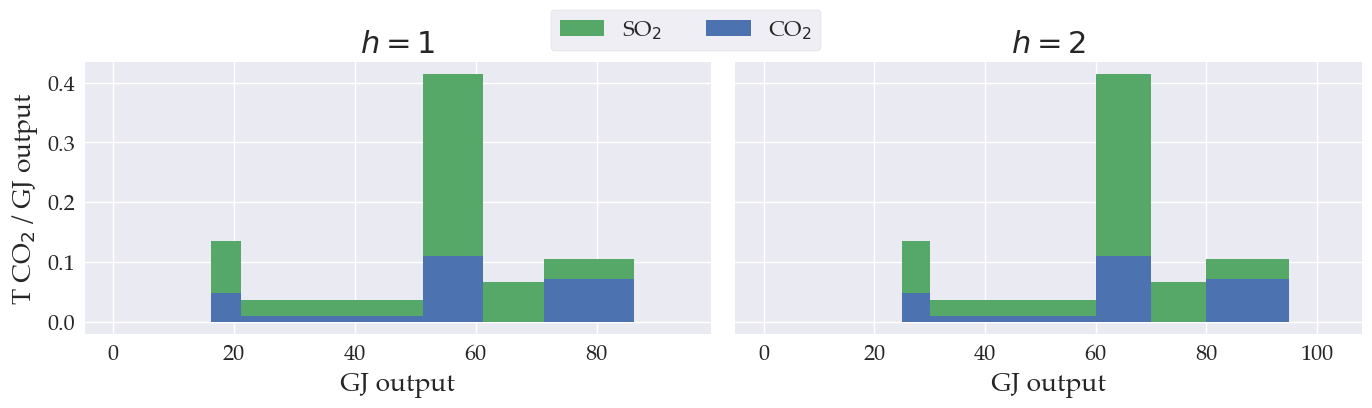

In [7]:
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=True);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    df = other_from_supply(h=h,mc=m.db['mc'],production=m.hourlyGeneratingCapacity,other= mBasicInt.plantEmissionIntensity(m.db).unstack('EmissionType'))
    # df = other_from_prices(h=h,mc=m.db['mc'],production=m.hourlyGeneratingCapacity,other= mBasicInt.plantEmissionIntensity(m.db).unstack('EmissionType'))
    h = j+1
    
    df.plot(kind='area',linewidth=0,ax=ax,legend=False,stacked=True);
    ax.set_ylabel(r'T CO$_2$ / GJ output', labelpad = 5);
    ax.set_xlabel(r'GJ output', labelpad = 5);
    # ax.set_xlim([0, max([dh.index.max(), df.index.max()])+5]);
    # ax.set_ylim([0, math.ceil(max([df.max()[0], dh.max()[0]]))]);
    ax.set_title(f"""$h={h}$""")

# fig.legend(['CO$_2$', 'SO$_2$'],loc=9,ncol=2,frameon=True)
legend_elements = [mpl.patches.Patch(facecolor=colors[1], edgecolor=None, label='SO$_2$'),
                   mpl.patches.Patch(facecolor=colors[0], edgecolor=None, label='CO$_2$')]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, frameon=True, bbox_to_anchor=(0.5, 0.9))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_Emissions_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_Emissions.pdf",edgecolor='k')

*Plot marginal fuel conumpstion:*

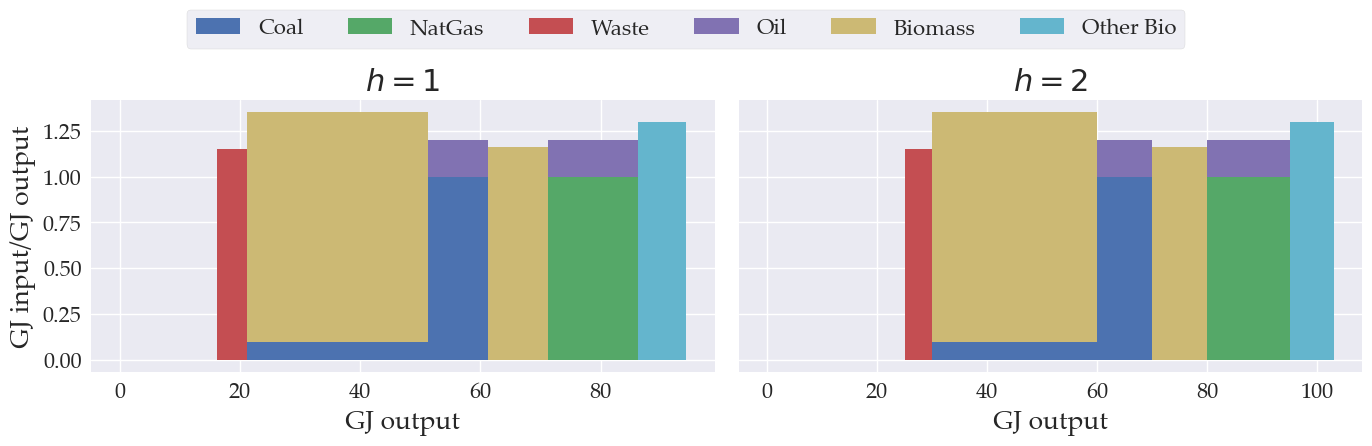

In [13]:
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=True);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    df = other_from_supply(h=h,mc=m.db['mc'],production=m.hourlyGeneratingCapacity,other= m.db['FuelMix'].unstack('BFt'))
    # df = other_from_prices(h=h,mc=m.db['mc'],production=m.hourlyGeneratingCapacity,other= m.db['FuelMix'].unstack('BFt'))
    agg_cols = {'Oil':['Fueloil','Gasoil'], 'Biomass':['Straw','WoodPellets','WoodChips','WoodWaste'],'Other Bio':['Biogas','BioOil']}
    for col in agg_cols.keys():
        df[col] = df[agg_cols[col]].sum(axis=1)
    df.drop(columns=[item for sublist in list(agg_cols.values()) for item in sublist],inplace=True) 

    h = j+1
    
    df.plot(kind='area',linewidth=0,ax=ax,legend=False,stacked=True);
    ax.set_ylabel(r'GJ input/GJ output', labelpad = 5);
    ax.set_xlabel(r'GJ output', labelpad = 5);
    # ax.set_xlim([0, max([dh.index.max(), df.index.max()])+5]);
    # ax.set_ylim([0, math.ceil(max([df.max()[0], dh.max()[0]]))]);
    ax.set_title(f"""$h={h}$""")

# fig.legend(['CO$_2$', 'SO$_2$'],loc=9,ncol=2,frameon=True)
fuels = df.columns
legend_elements = [mpl.patches.Patch(facecolor=colors[x], edgecolor=None, label=fuels[x]) for x in range(len(fuels))]
fig.legend(handles=legend_elements, loc='lower center', ncol=len(fuels), frameon=True, bbox_to_anchor=(0.5, 1))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_FuelConsumption_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_FuelConsumption.pdf",edgecolor='k')

#### 4.1. *Simulate experiment:*

To create the simulation, we use the ```loopSolveExtract``` method that we also used in [Exercise 1](E1_SolutionGuide.ipynb):

i) Create loop (with 51 gridpoints here):

In [56]:
loop = pd.Index(range(10), name = 'loop')

ii) Create grid of values to update throughout the loop by specifying first (```v0```) and final value in the loop (```vT```):

In [57]:
λ = 0.2
# Off-peak grid
v0 = pd.Series(db['LoadVariation'].min(), index = pd.Index(['c1'], name = 'c')) # 'id4' is the wind plant
vT = pd.Series(0.40, index = pd.Index(['c1'], name = 'c'))
OffPeakGrid = addGrid(v0, vT, loop, 'LoadVariation')# inputs are (1) first value in grid, (2) final value, (3) loop, (4) name of symbol
OffPeakGrid.index = pd.MultiIndex.from_tuples([(a[0],a[1],1) for a in OffPeakGrid.index], names=OffPeakGrid.index.names+['h'])

# Peak grid
step = OffPeakGrid.diff().fillna(0)
PeakGrid = pd.Series([db['LoadVariation'].max()-(1-λ)*s[-1]*s[0][0] for s in step.iteritems()],index=OffPeakGrid.rename({1:2},level='h').index,name='LoadVariation').sort_index()

# Common grid
LoadVariationGrid = OffPeakGrid.append(PeakGrid).sort_index()

iii) Specify which symbols to save in the simulations:

In [58]:
extract = ['Generation','marginalEconomicValue','marginalSystemCosts','LoadVariation','HourlyDemand','Welfare']

iv) Run simulation:

In [59]:
solution = m.loopSolveExtract(loop,[LoadVariationGrid],extract)

*Plot prices:*

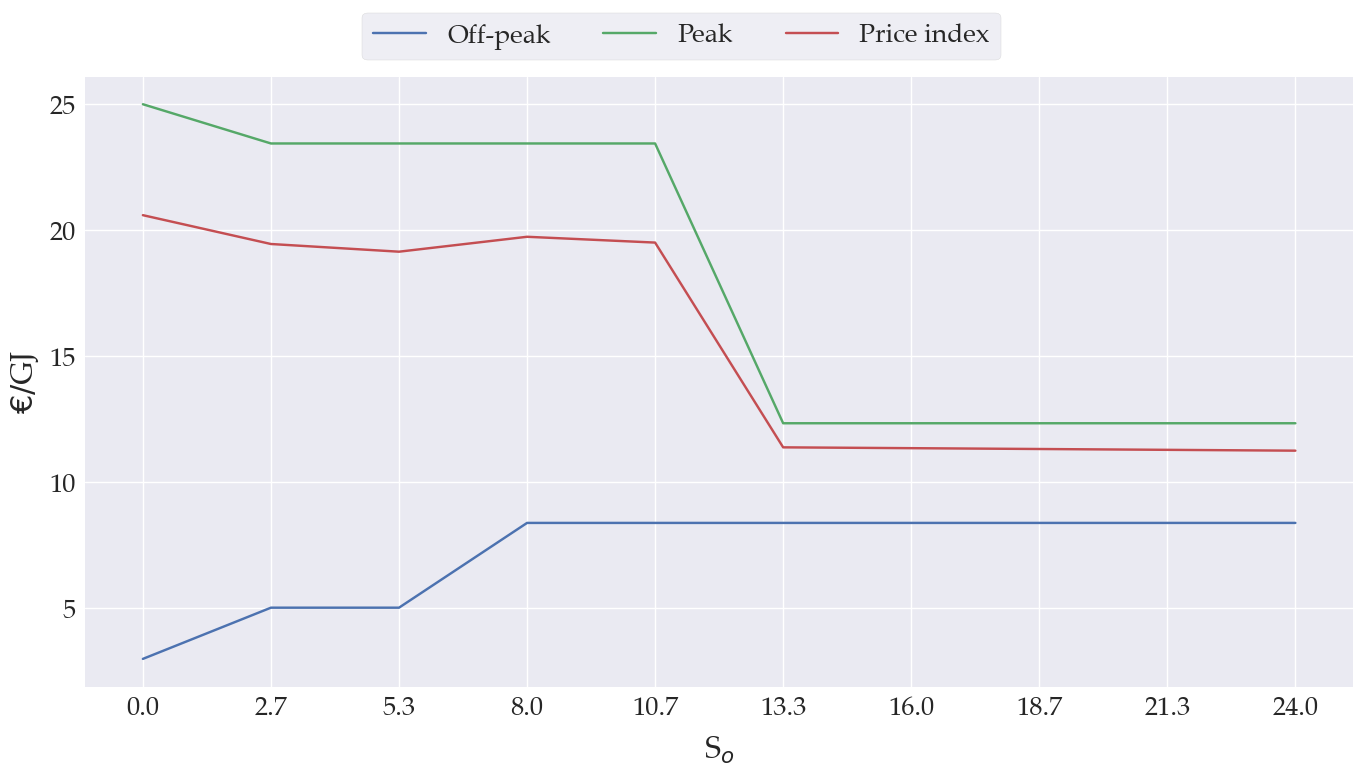

In [60]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
solution['marginalSystemCosts'].unstack('h').plot(ax=ax,legend=False)
(solution['marginalSystemCosts']*solution['LoadVariation']).groupby('loop').agg('sum').plot(ax=ax,legend=False)
ax.set_xticks(loop,labels=(step.cumsum()*db['Load']).astype(float).values.round(1))
ax.set_xlabel(r'S$_o$', labelpad=10);
ax.set_ylabel(r'$€/$GJ', labelpad = 5);

fig.legend(['Off-peak', 'Peak', 'Price index'],loc=9,ncol=3,frameon=True)
fig.tight_layout();
fig.subplots_adjust(top=0.9);

*Plot marginal values:*

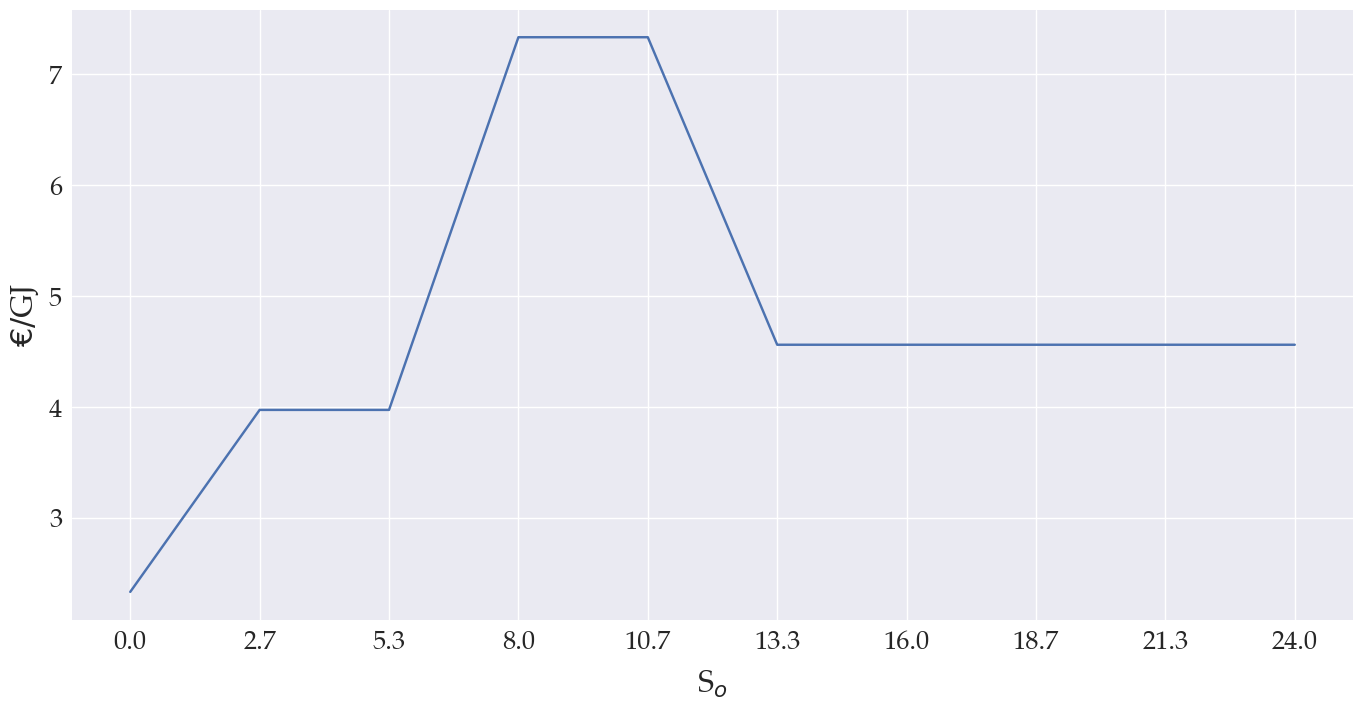

In [61]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
solution['marginalEconomicValue'][('id7',)].plot(ax=ax,legend=False)
# solution['marginalEconomicValue'].unstack('id').plot(ax=ax,legend=False)
ax.set_xticks(loop,labels=(step.cumsum()*db['Load']).astype(float).values.round(1))
ax.set_xlabel(r'S$_o$', labelpad=10);
ax.set_ylabel(r'$€/$GJ', labelpad = 5);
# fig.legend(['Off-peak', 'Peak', 'Price index'],loc=9,ncol=3,frameon=True)
fig.tight_layout();
fig.subplots_adjust(top=0.9);

*Plot practical capacity factor:*

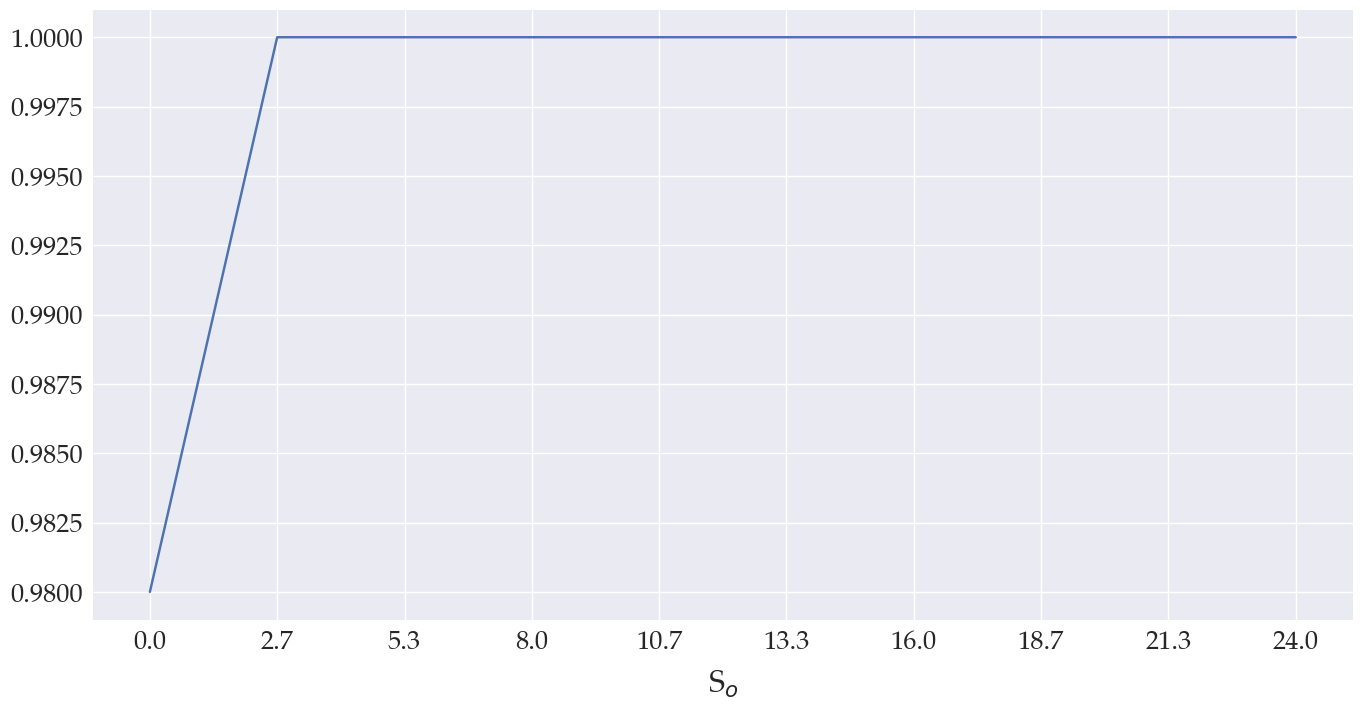

In [62]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
df = (solution['Generation'].xs('id7',level='id')/db['CapVariation'].xs('Wind',level='hvt')/2/db['GeneratingCapacity']['id7']).groupby('loop').agg('sum')
df.plot(ax=ax,legend=False)
ax.set_xticks(loop,labels=(step.cumsum()*db['Load']).astype(float).values.round(1))
ax.set_xlabel(r'S$_o$', labelpad=10);
fig.tight_layout();
fig.subplots_adjust(top=0.9);

*Plot profits:*

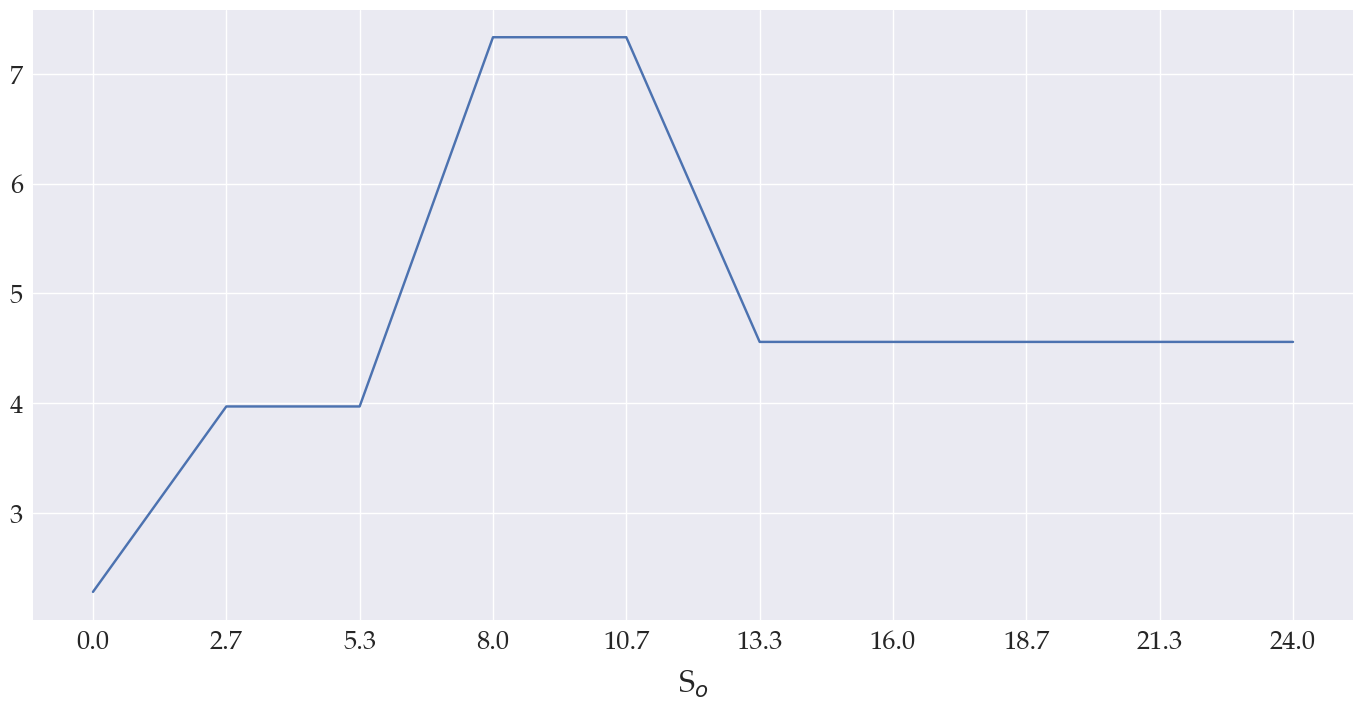

In [63]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
(solution['marginalEconomicValue'][('id7',)]*df).plot(ax=ax,legend=False)
ax.set_xticks(loop,labels=(step.cumsum()*db['Load']).astype(float).values.round(1))
ax.set_xlabel(r'S$_o$', labelpad=10);
fig.tight_layout();
fig.subplots_adjust(top=0.9);

*Plot welfare:*

In [99]:
# Producers
p = solution['marginalSystemCosts']
E = solution['Generation']
R = p*E
mc = db['mc']
VC = mc*E
fom = db['FOM']*1000*len(db['h'])/8760
FOM = fom*db['GeneratingCapacity']
id2tech = {x[0]:x[1] for x in db['id2tech']}
Π = (R-VC-FOM).groupby(['loop','id']).agg('sum').rename(id2tech,level='id').groupby(['loop','id']).agg('sum').rename_axis(['loop','agent']).rename('W')

# Consumers
Δp = db['MWP_LoadShedding']-p
S0 = (step.cumsum()*db['Load']).astype(float).droplevel('c')
L = solution['HourlyDemand']-S0
v = (Δp*L).groupby('loop').agg('sum').to_frame().assign(agent='Consumer').set_index('agent',append=True)[0].rename('W')

# Storage
π = p.unstack('h')
π['diff'] = (1-λ)*π[2]-π[1]
π = (π['diff']*S0.droplevel('h')).to_frame().assign(agent='Storage').set_index('agent',append=True)[0].rename('W')
# Combine dataframe
W = Π.append(v).append(π).sort_index()
W_neg, W_pos = W.groupby('agent').diff().clip(upper=0).unstack('agent').fillna(0), W.groupby('agent').diff().clip(lower=0).unstack('agent').fillna(0)

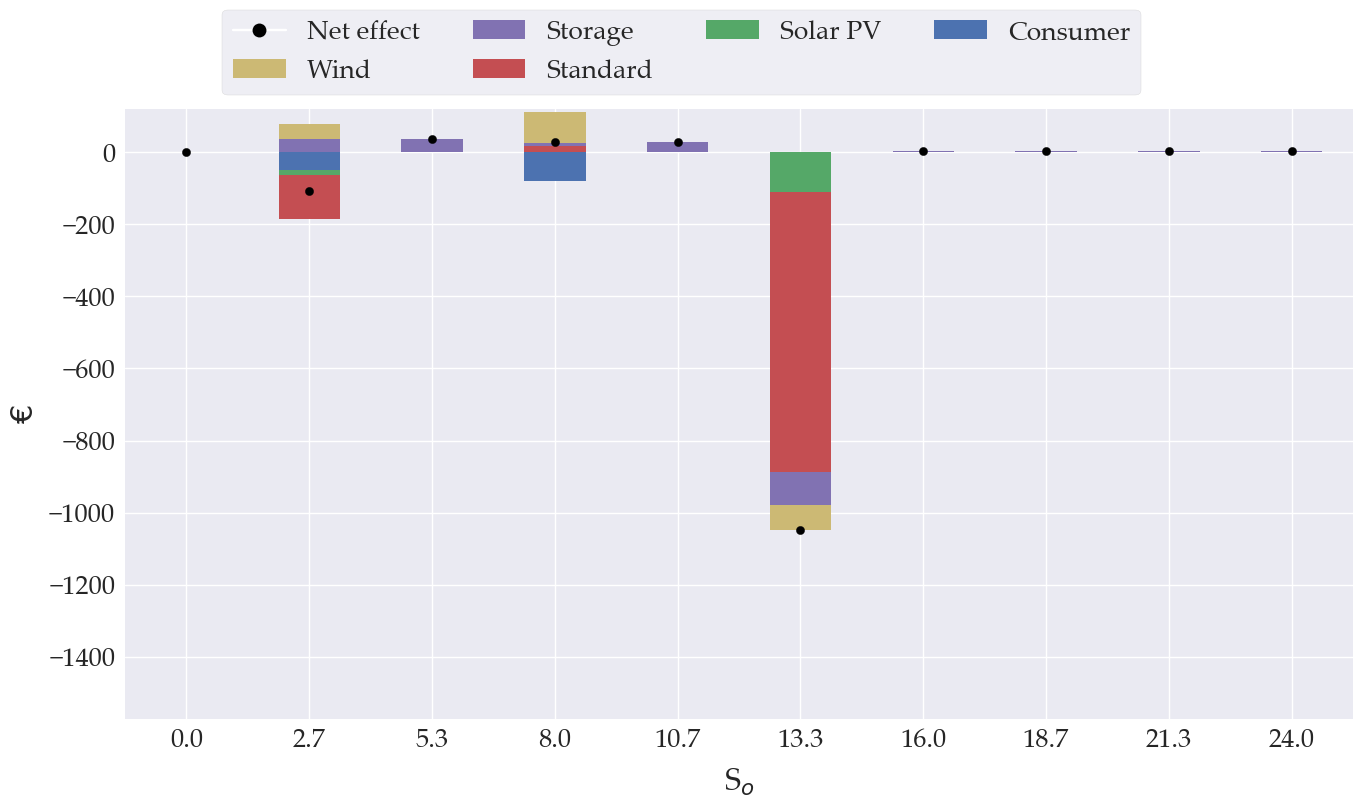

In [102]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
W_pos.plot.bar(ax=ax, stacked=True, linewidth=0.,legend=False)#, width=1.0)
ax.set_prop_cycle(None)
W_neg.rename(columns=lambda x: '_' + x).plot.bar(ax=ax, stacked=True, linewidth=0.,legend=False)#, width=1.0)
W.groupby('loop').agg('sum').diff().fillna(0).reset_index().plot.scatter(ax=ax,x='loop',y='W',color='black',s=35,marker='o')

# Axes
ax.set_ylim([W_neg.sum(axis=1).min()*1.5, W_pos.sum(axis=1).max()*1.1])
ax.set_xticks(loop,labels=(step.cumsum()*db['Load']).astype(float).values.round(1))
ax.set_xlabel(r'S$_o$', labelpad=10)
ax.set_ylabel(r'$€$',labelpad=5)

# General
legend_elements = [mpl.lines.Line2D([0], [0], marker='o',color='w', label='Net effect',markerfacecolor='black', markersize=10),
                   mpl.patches.Patch(facecolor=colors[4], edgecolor=None, label='Wind'),
                   mpl.patches.Patch(facecolor=colors[3], edgecolor=None, label='Storage'),
                   mpl.patches.Patch(facecolor=colors[2], edgecolor=None, label='Standard'),
                   mpl.patches.Patch(facecolor=colors[1], edgecolor=None, label='Solar PV'),
                   mpl.patches.Patch(facecolor=colors[0], edgecolor=None, label='Consumer')]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, frameon=True, bbox_to_anchor=(0.5, 0.9))
fig.tight_layout();
fig.subplots_adjust(top=0.9);